# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import os.path as path
import pickle

In [2]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

The accuracy of my dummy model is 6.87%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [3]:
# Write your codes here

#pred1, label1 = # train_and_test(...

from sklearn.neighbors import NearestNeighbors

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset_tiny(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            
            # resize and reshape
            origImg = cv2.imread(filename, 0)
            newImg = cv2.resize(origImg,(int(16),int(16)), interpolation = cv2.INTER_AREA) # cv2.INTER_AREA - best results
            newImg = np.reshape(newImg, [256,1])

            #normalization of the tiny images
            newImgNorm = newImg.astype(np.float32) 
            newImgNorm = newImgNorm / np.sum(newImgNorm)
            newImgNorm = newImgNorm - np.mean(newImgNorm)

            data.append(newImgNorm)
            
    return data, labels

# feature extraction
def extract_feat_tiny(raw_data):
    feat_dim = 256 # tiny - 16 X 16 
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))
        
    return feat

# load training dataset
train_start = time.time()
train_data, train_label = load_dataset_tiny('data/train/')
train_num = len(train_label)
train_feat = extract_feat_tiny(train_data)
train_time_taken = time.time() - train_start
print "time taken to Train(load and extract features) {:.3f}".format(train_time_taken), " seconds."

# load testing dataset
test_data, test_label = load_dataset_tiny('data/test/' , 100) # not ,100 but all
test_num = len(test_label)

print "train_num, test_num ", train_num, test_num 



## get features

test_feat = extract_feat_tiny(test_data)

# model training: take feature and label, return model
def train_tiny(X, Y):
    # do nothing as no training required for nearest neighbors
    pass

# prediction: take feature and model, return label
def predict_tiny(model, test_x, train_x, train_y):
    test_x = [test_x]
    distances, indices = model.kneighbors(return_distance=True, X=test_x)
    #print "distances , indices, train_y[indices[0][0]] ", distances, indices[0][0], train_y[indices[0][0]]
    return train_y[indices[0][0]]

# evaluation
predictions_tiny = [-1]*len(test_feat)
# Training is called coherence with other methods but does nothing for NearestNeighbors
train_tiny(train_feat, train_label)

# actual prediction 
pred_start = time.time()
# fit training features
model_tiny = NearestNeighbors(n_neighbors=1, algorithm='auto', p=2, metric='l2').fit(train_feat)
for i in xrange(test_num):
    predictions_tiny[i] = predict_tiny(model_tiny, test_feat[i], train_feat, train_label)
    
#print(predictions)
pred_time_taken = time.time() - pred_start
print "time taken to predict {:.3f}".format(pred_time_taken), " seconds."

accuracy = sum(np.array(predictions_tiny) == test_label) / float(test_num)

pred1, label1 = predictions_tiny, test_label
print "The accuracy of my Tiny Image model is {:.2f}%".format(accuracy*100)

time taken to Train(load and extract features) 1.224  seconds.
train_num, test_num  1500 1500
time taken to predict 1.580  seconds.
The accuracy of my Tiny Image model is 20.93%


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [4]:
# Write your codes here

#pred2, label2 = # train_and_test(...
######## ------------------------- Common Methods across Q2 and Q3  ---------------------------- ########
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sift = cv2.xfeatures2d.SIFT_create()
step_size = 50 # dense sift
radius = 40
n_clusters = 200
kmeans = KMeans(n_clusters = n_clusters,random_state=42)

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset_sift(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        
        for filename in img_path_class:
            
            # resize and reshape
            origImg = cv2.imread(filename, 0)
            data.append(origImg)
            #print " file loaded ", filename
            
    return data, labels

# load training dataset
train_data, train_label = load_dataset_sift('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset_sift('data/test/', 100) # not ,100 but all
test_num = len(test_label)

print("train_num, test_num ",train_num, test_num )

# initialize histograms - training features
histograms = np.array([np.zeros(n_clusters) for i in xrange(len(train_data))])
print " histograms.shape ", histograms.shape

def extract_descriptors_sift(raw_data):
    print "Starting extract_descriptors ...  "
    start_time = time.time()
    all_descriptors = list()
    for i in xrange(len(raw_data)):
        
        #kpts, dense_feat = sift.detectAndCompute(raw_data[i], None)
        #print("regular desc shape ",dense_feat.shape)
        # ---------------- start dense
        kpts = [cv2.KeyPoint(x, y, radius) for y in range(0, raw_data[i].shape[0], step_size) 
                                    for x in range(0, raw_data[i].shape[1], step_size)]

        #raw_data[i]=cv2.drawKeypoints(raw_data[i],kpts, raw_data[i])
        kpts, dense_feat = sift.compute(raw_data[i], kpts)
        # ---------------- end dense
        #print("dense feat shape ",len(dense_feat))
        #print("dense feat shape ",dense_feat)
        
        all_descriptors.append(dense_feat)

    end_time = time.time() - start_time
    #print "Returning descriptors after processing images# ",len(raw_data), " with descriptors# ", len(all_descriptors)
    print "time taken ", end_time
    return all_descriptors
    

def getClusters_sift(all_descriptors):
    print "Starting kClusters ... all_descriptors[0]  ",all_descriptors[0].shape
    start_time = time.time() 
    descVStk = np.array(all_descriptors[0]) # create Vstack with first element
    for rest in all_descriptors[1:]: # stack the rest
        descVStk = np.vstack((descVStk, rest))
    
    print "starting to fit clusters.... descVStk.shape ", descVStk.shape
    kmeans_output = kmeans.fit_predict(descVStk) # labels of cluster centroids 
    
    end_time = time.time() - start_time
    #print "Returning from kClusters ", len(kmeans_output)
    #print "Returning from kClusters ", kmeans_output
    #print "Returning from kClusters.cluster_centers_ ", kmeans_output.cluster_centers_
    print "time taken in seconds", end_time
    return kmeans_output, kmeans



('train_num, test_num ', 1500, 1500)
 histograms.shape  (1500, 200)


In [5]:
######## ------------------------- Common Methods across Q2 and Q3  ---------------------------- ########

def normalize_histograms_sift(histograms):
    # scale histogram
    scale = StandardScaler().fit(histograms)
    histograms = scale.transform(histograms)
    
    return scale, histograms


# feature extraction
def extract_histograms_sift(raw_data, descriptors, kmeans_output):
    
    print "Starting extract_histograms ...  "
    start_time = time.time() 
    
    histograms = np.array([np.zeros(n_clusters) for i in xrange(len(raw_data))])
    # for each image
    current_desc_count = 0
    for each_img_idx in xrange(len(raw_data)):

        len_desc = len(descriptors[each_img_idx])
        #print "descriptor length ",len_desc
        
        for each_desc_idx in range(len_desc):
            clustr_indx = kmeans_output[current_desc_count + each_desc_idx]
            histograms[each_img_idx][clustr_indx] += 1
            
        current_desc_count += len_desc
        #plt.figure(figsize=(4,4))
        #plt.hist(histograms[i], bins='auto')
    
    end_time = time.time() - start_time
    print "Histograms generation complete ....."
    print "time taken in seconds ", end_time
    return histograms

print "Starting TRAINING ....."
train_start_time = time.time()
train_desc_sift = extract_descriptors_sift(train_data)
#kClustrs_sift, kmeans = getClusters_sift(train_desc_sift)


clusters_siftnn_file = "clusters_siftnn.pkl"
kmeans_siftnn_file = "kmeans_siftnn.pkl"

if not path.isfile(clusters_siftnn_file) or not path.isfile(kmeans_siftnn_file):
    kClustrs_sift, kmeans = getClusters_sift(train_desc_sift)
    with open(clusters_siftnn_file, 'wb') as cl_file:
        pickle.dump(kClustrs_sift, cl_file)
        print '{:s} file has been saved'.format(clusters_siftnn_file)
    with open(kmeans_siftnn_file, 'wb') as cl_file:
        pickle.dump(kmeans, cl_file)
        print '{:s} file has been saved'.format(kmeans_siftnn_file)
else:
    with open("./"+clusters_siftnn_file, 'rb') as cl_file:
        kClustrs_sift = pickle.load(cl_file)
    with open("./"+kmeans_siftnn_file, 'rb') as cl_file:
        kmeans = pickle.load(cl_file)
    print 'Files has been loaded from disk ',clusters_siftnn_file, kmeans_siftnn_file


Starting TRAINING .....
Starting extract_descriptors ...  
time taken  22.5577440262
Files has been loaded from disk  clusters_siftnn.pkl kmeans_siftnn.pkl


In [6]:


# get historgrams as training features and normalize
train_feat_sift = extract_histograms_sift(train_data, train_desc_sift,kClustrs_sift)
scale_sift, train_feat_sift = normalize_histograms_sift(train_feat_sift)

train_time = time.time() - train_start_time
print "time taken to TRAIN in seconds {:.3f}".format(train_time)


# model training: take feature and label, return model
def train_siftnn(X, Y):

    # do nothing as no training required for nearest neighbors
    pass

# prediction: take feature and model, return label
def predict_siftnn(model, test_x, train_x, train_y):
    
    distances, indices = model.kneighbors(test_x)
    #print "train_y[indices[0][0]] ",train_y[indices[0][0]]
    return train_y[indices[0][0]]

# evaluation
predictions_siftnn = list() #[-1]*len(test_data)
# Training is called coherence with other methods but does nothing for NearestNeighbors
train_siftnn(train_feat_sift, train_label)

print "Starting TESTING ....."
print " Train and Test counts", len(train_data), len(test_data)
pred_start = time.time()
# setup model with params
model_siftnn = NearestNeighbors(n_neighbors=1, algorithm='auto', p=2, metric='l2', n_jobs=-1).fit(train_feat_sift)

for i in xrange(test_num):
    
    #kpts, dense_feat_tst = sift.detectAndCompute(test_data[i], None)
    
    kpts = [cv2.KeyPoint(x, y, radius) for y in range(0, test_data[i].shape[0], step_size) 
                                for x in range(0, test_data[i].shape[1], step_size)]

    #test_data[i]=cv2.drawKeypoints(test_data[i],kpts, test_data[i])
    kpts, dense_feat_tst = sift.compute(test_data[i], kpts)
    
    #print des.shape

    # test image histograms
    hist_test = np.array( [[ 0 for i in xrange(n_clusters)]])

    #find clusters
    pred_y = kmeans.predict(dense_feat_tst)
    #print 'pred_y ',pred_y

    # setup histogram
    for each in pred_y:
        hist_test[0][each] += 1

    # Scale the features
    hist_test = scale_sift.transform(hist_test)

    # predict the class of the image
    predictions_siftnn.append(predict_siftnn(model_siftnn, hist_test, train_feat_sift, train_label)) 
    
    
#print("predictions >> ",predictions_siftnn)
pred_time_taken = time.time() - pred_start
print "time taken to TEST in seconds {:.3f}".format(pred_time_taken)

accuracy = sum(np.array(predictions_siftnn) == test_label) / float(test_num)

pred2, label2 = predictions_siftnn, test_label
#print "accuracy ", accuracy
print "The accuracy of my SIFT + Nearest Neighbors model is {:.2f}%".format(accuracy*100)

Starting extract_histograms ...  
Histograms generation complete .....
time taken in seconds  0.0424480438232
time taken to TRAIN in seconds 22.683
Starting TESTING .....
 Train and Test counts 1500 1500


/home/shayan_ray/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


time taken to TEST in seconds 212.450
The accuracy of my SIFT + Nearest Neighbors model is 50.40%


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [7]:
##### reusing all the clusters and histograms from training data collected for Q2 #######
print "Starting training .. with existing trained clusters and descriptors"

### params to tweak
step_size = 50 # dense sift
radius = 20    #dense sift
n_clusters = 200


train_start_time = time.time()

train_desc_sift = extract_descriptors_sift(train_data)
clusters_siftsvm_file = "clusters_siftsvm.pkl"
kmeans_siftsvm_file = "kmeans_siftsvm.pkl"
if not path.isfile(clusters_siftsvm_file) or not path.isfile(kmeans_siftsvm_file):
    kClustrs_sift, kmeans = getClusters_sift(train_desc_sift)
    with open(clusters_siftsvm_file, 'wb') as cl_file:
        pickle.dump(kClustrs_sift, cl_file)
        print '{:s} file has been saved'.format(clusters_siftsvm_file)
    with open(kmeans_siftsvm_file, 'wb') as cl_file:
        pickle.dump(kmeans, cl_file)
        print '{:s} file has been saved'.format(kmeans_siftsvm_file)
else:
    with open("./"+clusters_siftsvm_file, 'rb') as cl_file:
        kClustrs_sift = pickle.load(cl_file)
    with open("./"+kmeans_siftsvm_file, 'rb') as cl_file:
        kmeans = pickle.load(cl_file)
    print 'Files has been loaded from disk ',clusters_siftsvm_file, kmeans_siftsvm_file
        
  
#kClustrs_sift = getClusters_sift(train_desc_sift)
train_feat_siftsvm = extract_histograms_sift(train_data, train_desc_sift,kClustrs_sift)
scale_siftsvm, train_feat_siftsvm = normalize_histograms_sift(train_feat_siftsvm)
svms = LinearSVC(C=0.091, tol=5e-3, loss='hinge', penalty='l2', random_state=42)

# model training: take feature and label, return model
def train_siftsvm(X, Y):

    return svms.fit(X,Y) 

# prediction: take feature and model, return label
def predict_siftsvm(test_x, svms):
    
    pred_Y = svms.predict(test_x)
    return pred_Y[0]
    

# evaluation
predictions_siftsvm = list() #[-1]*len(test_feat)
svms = train_siftsvm(train_feat_siftsvm, train_label)


train_time = time.time() - train_start_time
print "time taken to TRAIN in seconds {:.3f}".format(train_time)


print "Starting TESTING ....."
pred_start = time.time()
for i in xrange(test_num):
    
    #kpts, dense_feat_tst2 = sift.detectAndCompute(test_data[i], None)
    #print("regular desc shape ",desc.shape)
    kpts = [cv2.KeyPoint(x, y, radius) for y in range(0, test_data[i].shape[0], step_size) 
                                for x in range(0, test_data[i].shape[1], step_size)]

    #test_data[i]=cv2.drawKeypoints(test_data[i],kpts, test_data[i])
    kpts, dense_feat_tst2 = sift.compute(test_data[i], kpts)
    #print des.shape

    # setup histogram 
    hist_test = np.array( [[ 0 for i in xrange(n_clusters)]])

    pred_y = kmeans.predict(dense_feat_tst2)
    # print test_ret

    # setup histogram for each cluster
    for each in pred_y:
        hist_test[0][each] += 1

    # scaling
    hist_test = scale_siftsvm.transform(hist_test)

    # make predictions and append
    predictions_siftsvm.append(predict_siftsvm(hist_test, svms))
    
#print("predictions >> ",predictions_siftsvm)
pred_time_taken = time.time() - pred_start
print ("time taken to TEST in seconds {:.3f}".format(pred_time_taken))

accuracy = sum(np.array(predictions_siftsvm) == test_label) / float(test_num)

pred3, label3 = predictions_siftsvm, test_label
print "The accuracy of SIFT + Linear SVM (Multi-class) model is {:.2f}%".format(accuracy*100)

Starting training .. with existing trained clusters and descriptors
Starting extract_descriptors ...  
time taken  9.82657194138
Files has been loaded from disk  clusters_siftsvm.pkl kmeans_siftsvm.pkl
Starting extract_histograms ...  
Histograms generation complete .....
time taken in seconds  0.0422370433807
time taken to TRAIN in seconds 10.999
Starting TESTING .....
time taken to TEST in seconds 14.527
The accuracy of SIFT + Linear SVM (Multi-class) model is 58.27%


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**My Environment Specs:** <br>

-- Google Cloud Platform: n1-standard-8 (8 vCPUs, 30 GB memory)

-- Python 2.7.15 :: Anaconda, Inc.

-- OpenCv 3.4.2

As I was running on GCP, my cluster calculations were relatively fast and also stored separately in a file. And obviously that is why I am able to train and test faster than on a local laptop.


**First combination:** <br>

-- Tiny Images + Nearest Neighbors 

-- Time consumed and prediction accuracy 

    train and test image count: 1500 images 
    
    Time taken to load and extract features: 1.218  seconds. (loading and extracting features - since there is no actual training involved)
            
    Time taken to TEST/ Predict: 1.596  seconds (no training is required for Nearest neighbors hence that has not been mentioned)
    
    The accuracy of my Tiny Image model is 20.93%


-- Algorithm descriptions and discussions

As mentioned, the "tiny image" feature simply resizes each image to a small, fixed resolution. This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. 

The following parameters were modified to improve accuracy: 

This is the best permutation of parameters for me which yielded the best accuracy.

    cv2.resize() setting  interpolation = cv2.INTER_AREA improved accuracy significantly
    
    image sizes were truncated to 16 X 16
    
    images were normalized (to zero mean, unit length)
    
    NearestNeighbors(n_neighbors=1, algorithm='auto', p=2, metric='l2') # ‘auto’ algorithm will attempt to decide the most appropriate algorithm based on the values passed to fit method.


-- Confusion matrix observations

Note as per official documentation: The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

My observations:

Since the confusion matrix is normalized (that is, the values lie between 0 and 1), based on the diagonal colors and its labels, it is clear that for tiny images there are only a few labels that get successfully predicted and hence the accuracy is around 21%.


Worst Prediction Categories: 

    Stores  are the most mis-classified
    Industrial, Kitchen, Office, Living Room are amongst the other often mis-classfied image types.

Best Prediction Categories: 

    Highway, OpenCountry, Streets, Coast are most easily classified


**Second combination:** <br>

-- SIFT features + Nearest Neighbors 

-- Time consumed and prediction accuracy (time measured includes first time cluster creation)

    train and test image count: 1500 images 
            
    time taken to TRAIN in seconds 242.757 (no training is required for Nearest neighbors but clustering and histogram feature extraction is definitely quite expensive and part of training process before calling nearest neighbors)
    
    time taken to TEST in seconds 212.039
    
    The accuracy of my SIFT + Nearest Neighbors model is 50.40%

    
-- Algorithm descriptions and discussions
SIFT features are obviously way better than tiny images and they are scale invariant too unlike tiny images.
Regular SIFT features do not yield over 38% accuracy for me. Dense SIFT features obviously yield better results.(~50%)

Files to be loaded from disk:(once created the first time) - this improves performance of training and testing time

    clusters_siftnn.pkl : cluster labels after fit and predict
    
    kmeans_siftnn.pkl : kmeans object for test prediction

The following parameters were modified to improve accuracy:
This is the best permutation of parameters for me which yielded the best accuracy.

    step_size = 50     # dense sift

    n_clusters = 200   

    radius = 40        # dense sift

    NearestNeighbors(n_neighbors=1, algorithm='auto', p=2, metric='l2').fit(train_feat_siftnn) 
    # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.


Other parameter permutations tried out were: (with NN = 1)

step size=50, radius = 35, clusters = 200 => prediction accuracy = 49.2%

step size=40, radius = 35, clusters = 200 => prediction accuracy = 46.73%

step size=50, radius = 40, clusters = 200 => prediction accuracy = 50.4% (chosen)

step size=50, radius = 40, clusters = 250 => prediction accuracy = 48.48%

step size=50, radius = 20, clusters = 200 => prediction accuracy = 44.04%

step size=50, radius = 50, clusters = 200 => prediction accuracy = 49.53%

-- Confusion matrix observations

Note as per official documentation: The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

My observations:

Since the confusion matrix is normalized (that is, the values lie between 0 and 1), based on the diagonal colors and its labels, it is clear that for SIFT descriptors are far more superior that tiny images as input features.Hence the accuracy is around 50%.

Worst Prediction Categories: 
    
    Kitchen and Industrial are amongst the most mis-classified
  
Best Prediction Categories: 

    Forest, Street, Coast, OpenCountry, Suburb  are quite easily classified/recognized
    Classification of tallbuilding, mountain, insidecity have significantly improved with sift.


**Third combination:** <br>

-- SIFT features + Linear SVM 

-- Time consumed and prediction accuracy (time measured includes first time cluster creation)

    train and test image count: 1500 images
    
    time taken to TRAIN in seconds 218.630
    
    time taken to TEST in seconds 13.266
    
    The accuracy of SIFT + Linear SVM (Multi-class) model is 58.27%


-- Algorithm descriptions and discussions
SIFT features are obviously way better than tiny images and they are scale invariant too unlike tiny images. Linear SVC along with SIFT works better than NN.
Regular SIFT features do not yield over 38% accuracy for me. Dense SIFT features obviously yield much better results. Along with that Linear SVM takes care of one-vs-rest/all classification for multiple image types.

Files to be loaded from disk:(once created the first time) - this improves performance of training and testing time


    clusters_siftsvm.pkl : cluster labels after fit and predict
    
    kmeans_siftsvm.pkl : kmeans object for test prediction

The following parameters were modified to improve accuracy: 
This is the best permutation of parameters for me which yielded the best accuracy.

Note 'C' is inversely proportional to 'lambda' hence decreasing 'C' implies 'lambda' increases. (and vice versa)

    step_size = 50     # dense sift

    n_clusters = 200   

    radius = 20        # dense sift

    LinearSVC(C=0.091, tol=5e-3, loss='hinge', penalty='l2', random_state=42)


Other parameter permutations tried out were: 

step size=50, radius = 35, clusters = 200, C=0.1 => prediction accuracy = 54.0%

step size=40, radius = 35, clusters = 200, C=0.1 => prediction accuracy = 50.33%

step size=50, radius = 40, clusters = 200, C=0.1 => prediction accuracy = 51.13% 

step size=50, radius = 20, clusters = 200, C=0.1  => prediction accuracy = 55.05%

step size=50, radius = 20, clusters = 200, C=0.15 => prediction accuracy = 56.93%

step size=50, radius = 20, clusters = 200, C=0.092 => prediction accuracy = 58.07%

step size=50, radius = 20, clusters = 200, C=0.091 => prediction accuracy = 58.27% (chosen)


-- Confusion matrix observations
Note as per official documentation: The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

My observations:

Since the confusion matrix is normalized (that is, the values lie between 0 and 1), based on the diagonal colors and its labels, it is clear that for SIFT descriptors with SVM perform better than nearest neighbors .Hence the accuracy is around 58%


Worst Prediction Categories: 
    
    Kitchen, Industrial, Office and LivingRoom is amongst the most mis-classified. Still better probability of being detected compared to other 2 methods above.
  
Best Prediction Categories: 

    forest, suburbs and highway are quite easily classified/recognized
    
    Classification of coast, street, opencountry,store tallbuilding, mountain, insidecity also became easier with sift-svm.



<Figure size 864x864 with 0 Axes>

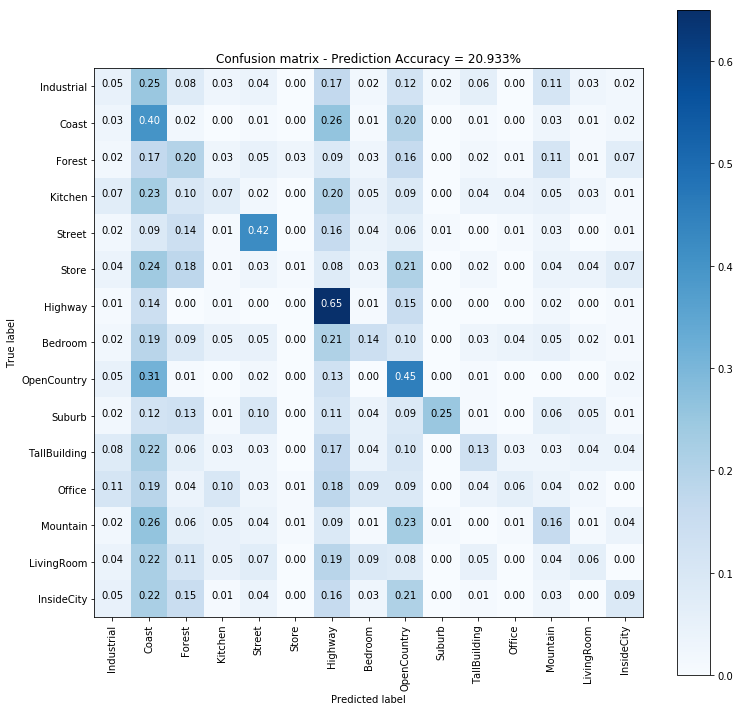

<Figure size 864x864 with 0 Axes>

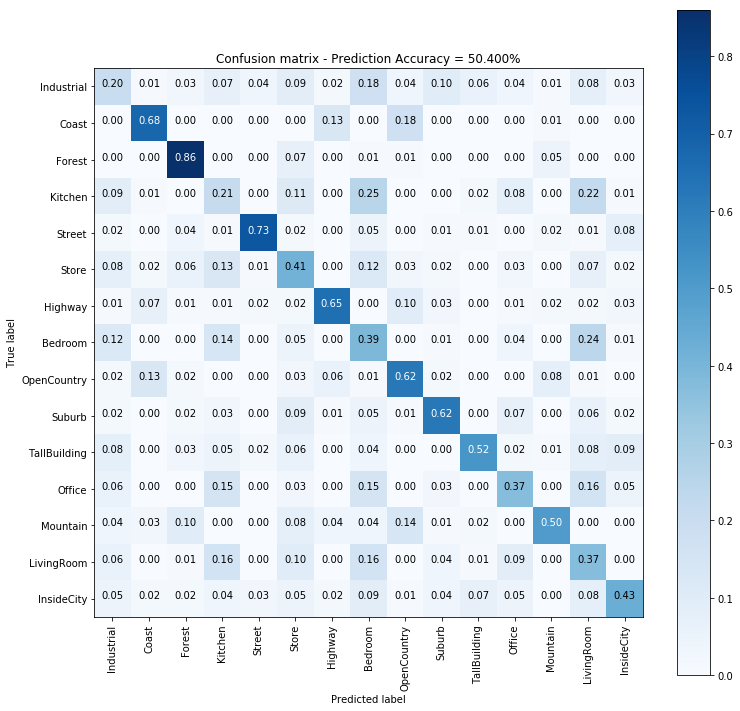

<Figure size 864x864 with 0 Axes>

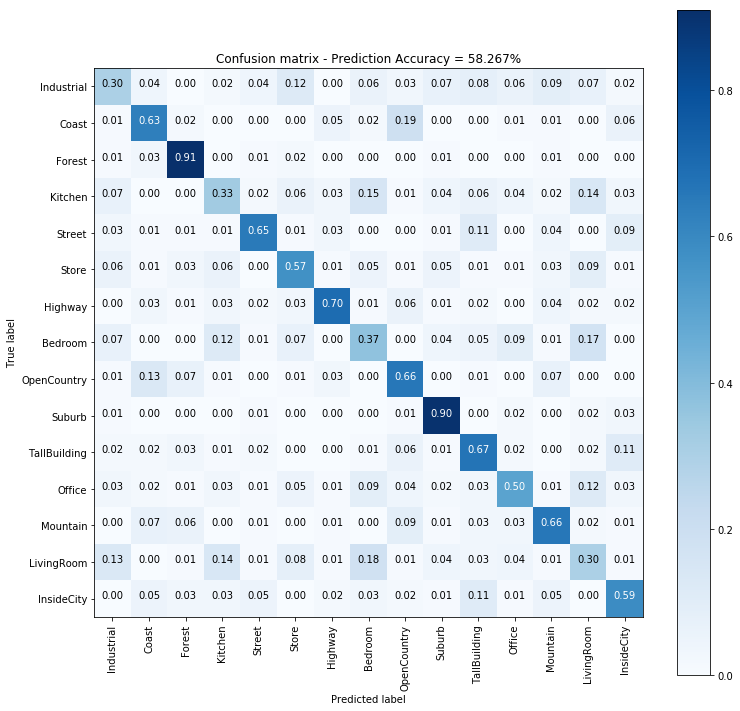

In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #normalization of confusion matrix
    if normalize == True:
        cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
    
    # calculate diagonal mean
    acc = np.mean(np.diag(cm))
    
    #show plot
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix - Prediction Accuracy = {:5.3f}%'.format(acc*100))
    tick_marks = np.arange(len(classes))
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

c_names = [name[11:] for name in glob.glob('data/train/*')]

#First combination:
# Confusion matrix
cm1 = confusion_matrix(label1,pred1) # fixed as per piazza confirmation
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(label2, pred2) # fixed as per piazza confirmation
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(label3, pred3) # fixed as per piazza confirmation
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>